In [118]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)

In [58]:
# Load the data
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [59]:
pd.set_option('display.max_columns', None)

In [60]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,sub_grade,home_ownership,annual_inc,verification_status,loan_status,purpose,addr_state,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg
1015107,15000.0,36,10.49,487.47,B3,MORTGAGE,60000.0,Not Verified,Fully Paid,debt_consolidation,CO,26.40,24,0,48654.0,36.1,42,Individual,2.0,682.0
1015108,36400.0,60,14.49,856.24,C4,RENT,95000.0,Verified,Charged Off,credit_card,CA,21.50,11,0,55723.0,79.8,24,Individual,6.0,722.0
1015109,18000.0,60,9.49,377.95,B2,OWN,130000.0,Not Verified,Fully Paid,home_improvement,TX,20.59,17,0,23833.0,34.0,39,Individual,3.0,737.0
1015110,29400.0,60,13.99,683.94,C3,MORTGAGE,180792.0,Not Verified,Fully Paid,debt_consolidation,CA,22.03,16,0,77480.0,85.2,32,Individual,3.0,707.0
1015111,24000.0,60,14.49,564.56,C4,RENT,110000.0,Not Verified,Charged Off,debt_consolidation,FL,18.30,10,1,17641.0,68.1,31,Individual,2.0,662.0


In [61]:
len(test_data.columns), len(train_data.columns)

(20, 20)

In [62]:
train_data.shape, test_data.shape

((1015112, 20), (127128, 20))

In [63]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015112 entries, 0 to 1015111
Data columns (total 20 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   loan_amnt            1015112 non-null  float64
 1   term (months)        1015112 non-null  int64  
 2   int_rate             1015112 non-null  float64
 3   installment          1015112 non-null  float64
 4   sub_grade            1015112 non-null  object 
 5   home_ownership       1015112 non-null  object 
 6   annual_inc           1015112 non-null  float64
 7   verification_status  1015112 non-null  object 
 8   loan_status          1015112 non-null  object 
 9   purpose              1015112 non-null  object 
 10  addr_state           1015112 non-null  object 
 11  dti                  1015112 non-null  float64
 12  open_acc             1015112 non-null  int64  
 13  pub_rec              1015112 non-null  int64  
 14  revol_bal            1015112 non-null  float64
 15

In [64]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  # Should we default

# Apply binary encoding to the target variable in the training DataFrame
train_data['Label'] = train_data[target_column].map(class_mapping)
test_data['Label'] = test_data[target_column].map(class_mapping)

In [65]:
print(train_data.shape)
train_data['Label'].value_counts(normalize=True) * 100


(1015112, 21)


Label
0    80.31104
1    19.68896
Name: proportion, dtype: float64

In [66]:
print(test_data.shape)
test_data['Label'].value_counts(normalize=True) * 100

(127128, 21)


Label
0    80.52514
1    19.47486
Name: proportion, dtype: float64

 Leaving 'term (months)' as a number 

In [67]:
train_data = train_data.drop('loan_status', axis = 1)
test_data = test_data.drop('loan_status', axis = 1)

In [68]:
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns

['sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'application_type']

In [69]:
for column in categorical_columns:
    unique_values = train_data[column].nunique()
    print(f"Column '{column}' has {unique_values} unique values.")

Column 'sub_grade' has 35 unique values.
Column 'home_ownership' has 4 unique values.
Column 'verification_status' has 3 unique values.
Column 'purpose' has 13 unique values.
Column 'addr_state' has 51 unique values.
Column 'application_type' has 2 unique values.


TODO : since home_ownership, verification_status, purpose and application_type have less than neary 10 categories we will use one hot encodign on them
target encoding for sub_grade and addr_state


In [70]:
cat_columns_ohe = ['home_ownership', 'verification_status', 'application_type', ]
cat_target_encoding = ['addr_state', 'sub_grade', 'purpose']

In [71]:
encoder = TargetEncoder(cols=cat_target_encoding)

encoder.fit(train_data[cat_target_encoding], train_data['Label'])

TargetEncoder(cols=['addr_state', 'sub_grade', 'purpose'])

In [72]:
X_train_encoded = encoder.transform(train_data[cat_target_encoding])
X_test_encoded = encoder.transform(test_data[cat_target_encoding])

# Replace original categorical columns with encoded columns in X_train and X_test
X_train_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]
X_test_encoded.columns = [f"{col}_encoded" for col in cat_target_encoding]

# Drop original categorical columns from X_train and X_test
train_data.drop(columns=cat_target_encoding, inplace=True)
test_data.drop(columns=cat_target_encoding, inplace=True)

# Concatenate encoded columns with remaining features
train_data = pd.concat([train_data, X_train_encoded], axis=1)
test_data = pd.concat([test_data, X_test_encoded], axis=1)

In [73]:
train_data.head()

,loan_amnt,term (months),int_rate,installment,home_ownership,annual_inc,verification_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,application_type,mort_acc,fico_avg,Label,addr_state_encoded,sub_grade_encoded,purpose_encoded
0,3600.0,36,13.99,123.03,MORTGAGE,55000.0,Not Verified,5.91,7,0,2765.0,29.7,13,Individual,1.0,677.0,0,0.206941,0.247340,0.208748
1,24700.0,36,11.99,820.28,MORTGAGE,65000.0,Not Verified,16.06,22,0,21470.0,19.2,38,Individual,4.0,717.0,0,0.216011,0.185845,0.296082
2,20000.0,60,10.78,432.66,MORTGAGE,63000.0,Not Verified,10.78,6,0,7869.0,56.2,18,Joint App,5.0,697.0,0,0.180676,0.144597,0.176489
3,10400.0,60,22.45,289.91,MORTGAGE,104433.0,Source Verified,25.37,12,0,21929.0,64.5,35,Individual,6.0,697.0,0,0.206941,0.422087,0.185110
4,11950.0,36,13.44,405.18,RENT,34000.0,Source Verified,10.20,5,0,8822.0,68.4,6,Individual,0.0,692.0,0,0.179856,0.223124,0.208748


In [74]:
combined_df = pd.concat([train_data, test_data], axis=0)
combined_df.reset_index(drop=True, inplace=True)
encoded_combined_df = pd.get_dummies(combined_df, columns=cat_columns_ohe, drop_first=True, prefix={col: col for col in cat_columns_ohe})
encoded_combined_df.reset_index(drop=True, inplace=True)


In [75]:
train_data = encoded_combined_df.iloc[:len(train_data)]
train_data.reset_index(drop=True, inplace=True)
test_data = encoded_combined_df.iloc[len(train_data):]
test_data.reset_index(drop=True, inplace=True)


In [76]:
train_data.tail()

,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg,Label,addr_state_encoded,sub_grade_encoded,purpose_encoded,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_Joint App
1015107,15000.0,36,10.49,487.47,60000.0,26.40,24,0,48654.0,36.1,42,2.0,682.0,0,0.156253,0.124942,0.208748,False,False,False,False,False,False
1015108,36400.0,60,14.49,856.24,95000.0,21.50,11,0,55723.0,79.8,24,6.0,722.0,1,0.193296,0.247340,0.165016,False,False,True,False,True,False
1015109,18000.0,60,9.49,377.95,130000.0,20.59,17,0,23833.0,34.0,39,3.0,737.0,0,0.195060,0.108556,0.176489,False,True,False,False,False,False
1015110,29400.0,60,13.99,683.94,180792.0,22.03,16,0,77480.0,85.2,32,3.0,707.0,0,0.193296,0.223124,0.208748,False,False,False,False,False,False
1015111,24000.0,60,14.49,564.56,110000.0,18.30,10,1,17641.0,68.1,31,2.0,662.0,1,0.209864,0.247340,0.208748,False,False,True,False,False,False


In [77]:
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
numerical_columns.remove('Label')
numerical_columns

['loan_amnt',
 'term (months)',
 'int_rate',
 'installment',
 'annual_inc',
 'dti',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc',
 'mort_acc',
 'fico_avg',
 'addr_state_encoded',
 'sub_grade_encoded',
 'purpose_encoded']

In [78]:
train_numerical_data = train_data[numerical_columns]
test_numerical_data = test_data[numerical_columns]

scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_numerical_data)
scaled_test_data = scaler.transform(test_numerical_data)

scaled_train_df = pd.DataFrame(scaled_train_data, columns=numerical_columns)
scaled_test_df = pd.DataFrame(scaled_test_data, columns=numerical_columns)

train_data = train_data.drop(columns=numerical_columns)
test_data = test_data.drop(columns=numerical_columns)

train_data = pd.concat([train_data, scaled_train_df], axis=1)
test_data = pd.concat([test_data, scaled_test_df], axis=1)


In [79]:
train_data.head()

,Label,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_Joint App,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg,addr_state_encoded,sub_grade_encoded,purpose_encoded
0,0,False,False,False,False,False,False,-1.286268,-0.565361,0.172192,-1.249038,-0.489626,-1.508192,-0.905402,-0.419464,-0.937226,-0.990623,-1.056469,-0.319472,-0.637247,0.515860,0.465840,0.533469
1,0,False,False,False,False,False,False,1.208124,-0.565361,-0.257948,1.499234,-0.222399,-0.252026,2.141049,-0.419464,0.501538,-1.433759,1.236796,1.305784,0.675289,0.981329,-0.101986,4.462278
2,0,False,False,False,False,False,True,0.652501,1.768781,-0.518182,-0.028604,-0.275844,-0.905480,-1.108499,-0.419464,-0.544633,0.127766,-0.597816,1.847536,0.019021,-0.832034,-0.482857,-0.917751
3,0,False,False,False,True,False,False,-0.482388,1.768781,1.991681,-0.591265,0.831361,0.900182,0.110082,-0.419464,0.536843,0.478054,0.961604,2.389288,0.019021,0.515860,2.079407,-0.529925
4,0,False,False,True,True,False,False,-0.299151,-0.565361,0.053903,-0.136919,-1.050805,-0.977261,-1.311596,-0.419464,-0.471329,0.642648,-1.698583,-0.861224,-0.145046,-0.874120,0.242244,0.533469


In [80]:
X_train  = train_data.drop("Label", axis = 1)
y_train = train_data["Label"]
X_test = test_data.drop("Label", axis = 1)
y_test = test_data["Label"]



In [81]:
X_test.head()

,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,verification_status_Source Verified,verification_status_Verified,application_type_Joint App,loan_amnt,term (months),int_rate,installment,annual_inc,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,mort_acc,fico_avg,addr_state_encoded,sub_grade_encoded,purpose_encoded
0,False,False,True,True,False,False,-1.357198,-0.565361,-1.258022,-1.367009,-0.569795,-2.167834,-0.905402,-0.419464,-1.139060,-2.222962,0.502951,1.305784,2.151891,-2.024261,-1.207570,-0.529925
1,False,True,False,False,False,False,-1.120763,-0.565361,-0.260098,-1.079549,-0.489626,-0.484695,0.516275,1.884179,-0.269264,-0.813369,-0.047433,-0.861224,-0.637247,-0.874120,-0.305854,0.613733
2,False,False,False,False,True,False,-0.884328,-0.565361,-0.260098,-0.817788,-0.890468,0.266529,0.313178,-0.419464,-0.765005,-0.724742,0.411221,-0.861224,0.019021,-0.093889,-0.305854,-0.917751
3,False,True,False,False,True,False,1.834677,-0.565361,1.862640,2.772800,-0.436181,1.173692,-0.093015,-0.419464,1.097811,0.001156,0.136029,0.222280,-0.473180,0.665860,1.265520,0.533469
4,False,True,False,True,False,False,0.770718,1.768781,1.548638,0.477023,0.312057,-0.289154,0.719372,-0.419464,-0.027586,-0.800708,0.227759,0.764032,-0.965381,1.104463,1.194070,1.407228


In [82]:
#Ensure the columsn are in same order as train ( they are different above)
X_test = X_test[X_train.columns]

In [83]:
X_test.shape,y_test.shape, X_train.shape, y_train.shape

((127128, 22), (127128,), (1015112, 22), (1015112,))

In [84]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

The SGDClassifier estimator in scikit-learn implements linear classifiers (SVM, logistic regression, and others) with stochastic gradient descent (SGD) training. A particular linear classifier is chosen through the loss hyperparameter. Because we want to predict the probability of charge-off, we choose logistic regression (a probabilistic classifier) by setting loss = 'log'.

In [85]:
X_train.shape

(1015112, 22)

In [86]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE

In [96]:
model = SGDClassifier(loss='log_loss', tol=1e-3, warm_start=True,  random_state=42 )

#early_stopping=True, validation_fraction=0.1, n_iter_no_change=5,

In [100]:
param_grid_sgdlogreg = {
    'alpha': [0.0001, 0.001, 0.01, 1, 10],
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced'],
    'max_iter': [500, 1000, 2000]
}

In [105]:
grid_sgdlogreg = GridSearchCV(estimator=model, param_grid=param_grid_sgdlogreg, scoring='roc_auc', n_jobs=-1, pre_dispatch='2*n_jobs', cv=5, verbose=1, return_train_score=False)



In [106]:
grid_sgdlogreg.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=5,
             estimator=SGDClassifier(loss='log_loss', random_state=42,
                                     warm_start=True),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 1, 10],
                         'class_weight': [None, 'balanced'],
                         'max_iter': [500, 1000, 2000],
                         'penalty': ['l1', 'l2']},
             scoring='roc_auc', verbose=1)

In [107]:
grid_sgdlogreg.best_score_

0.7136788914953502

In [108]:
grid_sgdlogreg.best_params_

{'alpha': 0.001, 'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1'}

In [110]:
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
hyper_params = [{'n_features_to_select': list(range(1, 22))}]


# create model
model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3, random_state=42, warm_start=True, penalty='l1', alpha= 0.001, class_weight='balanced')
model.fit(X_train, y_train)
rfe = RFE(model)

# call GridSearchCV() with r2score
model_cv_roc_auc = GridSearchCV(estimator = rfe,
                        param_grid = hyper_params,
                        scoring= 'roc_auc',
                        cv = folds,
                        verbose = 1,
                        return_train_score=True)

In [111]:
model_cv_roc_auc.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=SGDClassifier(alpha=0.001,
                                                   class_weight='balanced',
                                                   loss='log_loss',
                                                   penalty='l1',
                                                   random_state=42,
                                                   warm_start=True)),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21]}],
             return_train_score=True, scoring='roc_auc', verbose=1)

In [112]:
cv_results_roc_auc = pd.DataFrame(model_cv_roc_auc.cv_results_)
cv_results_roc_auc

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_features_to_select,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,29.802560,1.710700,0.069450,0.006751,1,{'n_features_to_select': 1},0.692070,0.693397,0.693250,0.694101,0.692138,0.692991,0.000779,21,0.693222,0.692893,0.692928,0.692715,0.693207,0.692993,0.000195
1,29.237294,0.335978,0.071274,0.002522,2,{'n_features_to_select': 2},0.694117,0.695799,0.695501,0.696741,0.693997,0.695231,0.001043,20,0.695524,0.695107,0.695179,0.694868,0.695534,0.695243,0.000256
2,28.575092,0.275097,0.072750,0.006983,3,{'n_features_to_select': 3},0.700977,0.701764,0.702169,0.702851,0.700333,0.701619,0.000884,19,0.701842,0.701687,0.701619,0.701162,0.701746,0.701611,0.000236
3,28.076000,0.455139,0.074250,0.002003,4,{'n_features_to_select': 4},0.702418,0.705235,0.703463,0.704775,0.702001,0.703578,0.001267,18,0.703156,0.705186,0.703070,0.702696,0.703393,0.703500,0.000872
4,27.099083,0.446107,0.081795,0.008824,5,{'n_features_to_select': 5},0.706902,0.707075,0.707393,0.708709,0.705832,0.707182,0.000926,17,0.707106,0.707420,0.707171,0.706754,0.707497,0.707190,0.000262
5,25.953934,0.172918,0.074242,0.001851,6,{'n_features_to_select': 6},0.708870,0.709413,0.708937,0.710554,0.707647,0.709084,0.000938,16,0.708809,0.709748,0.708945,0.708448,0.709251,0.709040,0.000438
6,24.664195,0.097300,0.075665,0.002366,7,{'n_features_to_select': 7},0.710771,0.709401,0.711370,0.712363,0.710024,0.710786,0.001032,15,0.710988,0.709812,0.711000,0.710651,0.711314,0.710753,0.000515
7,23.447393,0.111946,0.076708,0.001325,8,{'n_features_to_select': 8},0.711109,0.710470,0.711671,0.712696,0.710374,0.711264,0.000856,14,0.711339,0.711133,0.711374,0.711019,0.711668,0.711306,0.000223
8,22.679096,0.253370,0.084795,0.006848,9,{'n_features_to_select': 9},0.711614,0.711172,0.712389,0.713106,0.710680,0.711792,0.000864,13,0.712016,0.712050,0.711920,0.711672,0.711966,0.711925,0.000134
9,21.114549,0.160447,0.075995,0.002476,10,{'n_features_to_select': 10},0.712372,0.712480,0.713104,0.714276,0.711772,0.712801,0.000850,12,0.712882,0.713100,0.712728,0.712480,0.713192,0.712876,0.000256


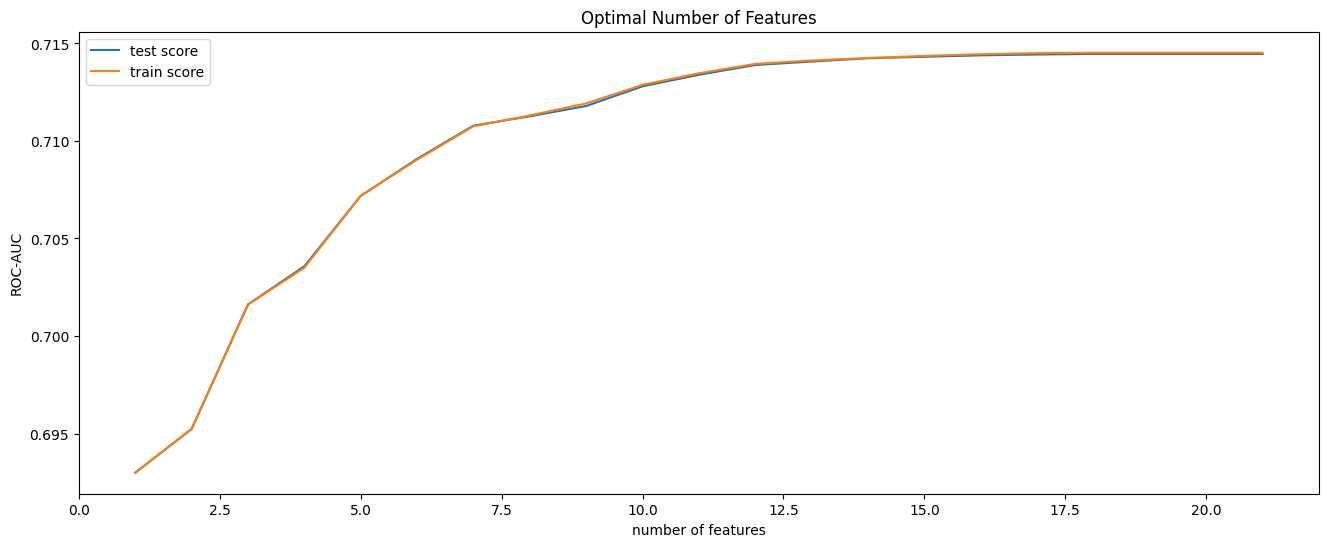

In [114]:

# plotting cv results
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))

plt.plot(cv_results_roc_auc["param_n_features_to_select"], cv_results_roc_auc["mean_test_score"])
plt.plot(cv_results_roc_auc["param_n_features_to_select"], cv_results_roc_auc["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('ROC-AUC')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')

In [115]:
def print_score(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")

In [116]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [119]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 66.29%
_______________________________________________
CLASSIFICATION REPORT:
                       0              1  accuracy     macro avg  weighted avg
precision       0.883689       0.321516  0.662939  6.026028e-01  7.730033e-01
recall          0.668261       0.641228  0.662939  6.547446e-01  6.629387e-01
f1-score        0.761023       0.428287  0.662939  5.946550e-01  6.955110e-01
support    815247.000000  199865.000000  0.662939  1.015112e+06  1.015112e+06
_______________________________________________
Confusion Matrix: 
 [[544798 270449]
 [ 71706 128159]]

Test Result:
Accuracy Score: 66.54%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.882690      0.318389  0.665369       0.600539       0.772793
recall          0.674016      0.629615  0.665369       0.651815       0.665369
f1-score        0.764367      0.422915  0.665369      

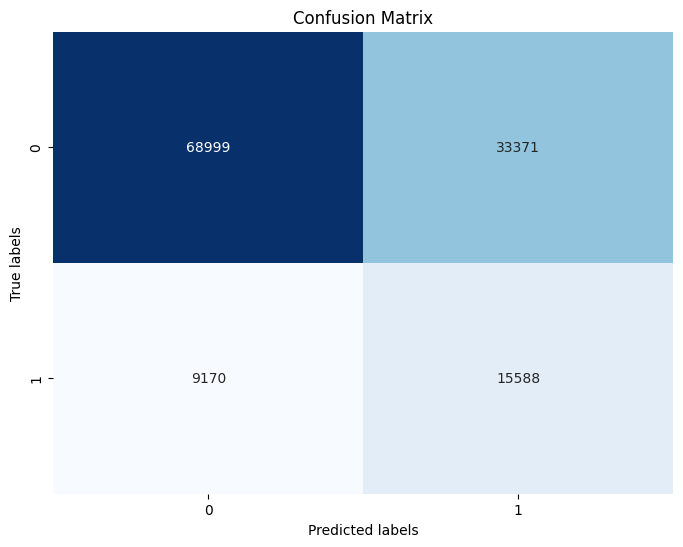

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are your true and predicted labels
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [124]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import RocCurveDisplay, roc_curve

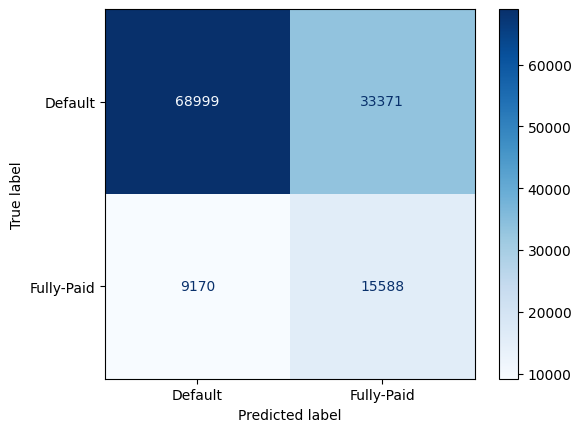

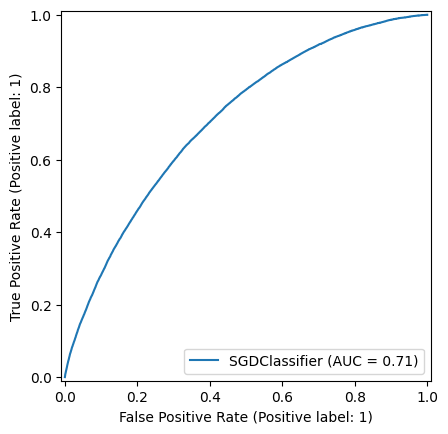

In [125]:
# Reducing FP or decreasing FN
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test, 
    cmap='Blues', values_format='d', 
    display_labels=['Default', 'Fully-Paid']
)

disp = RocCurveDisplay.from_estimator(model, X_test, y_test)